In [2]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import numpy as np
import pandas as pd
import os
import matplotlib2tikz
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=4, rc={"lines.markersize": 15})
plt.rc('hatch', color='white', linewidth=4)
plt.rcParams.update({
    "font.family": "serif",
     "font.serif": [] ,
      "font.sans-serif": []  })

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results'


SYSTEM_COLOR = sns.color_palette()[0]
BASELINE_COLOR = sns.color_palette()[1]

WRITE_DIRECTORY_ROOT = \
'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/papers/images/experiment-results'

output_directory = WRITE_DIRECTORY_ROOT + '/openml/model_materialization'
def create_folder(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

In [3]:
MODE = 'local'
result_folder = ROOT_RESULT_FOLDER + '/' + MODE + '/model_materialization/openml'
result_file = result_folder + '/2019-10-12/22-31.csv'

In [4]:
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'pipeline', 'setup', 'type', 'score',
    'current_run_time', 'best_setup', 'best_pipeline', 'best_score',
    'best_run_time', 'total_run_time'
]

method_map = {'optimized': 'CO', 'baseline': 'OML'}
execution_times = pd.read_csv(result_file, header=None, names=HEADERS)

execution_times['cumulative_run_time'] = execution_times.groupby(
    ['exp_id', 'type'])['total_run_time'].apply(lambda x: x.cumsum())
execution_times['cumulative_best_run_time'] = execution_times.groupby(
    ['exp_id', 'type'])['best_run_time'].apply(lambda x: x.cumsum())
execution_times['cumulative_current_run_time'] = execution_times.groupby(
    ['exp_id', 'type'])['current_run_time'].apply(lambda x: x.cumsum())
execution_times['workload'] = execution_times.groupby(['exp_id', 'type'
                                                       ]).cumcount() + 1
execution_times['type'] = execution_times['type'].replace(method_map)

In [19]:
def plot_executions_time(df, y='cumulative_run_time',loc=None):
    plt.figure(figsize=(7,4))
    plot = sns.lineplot(
        data=df,
        x='workload',
        y=y,
        hue='type',
        style='type',
        #markers=["^", "o"],
        lw=3,
        hue_order=['OML', 'CO'],
       # style_order = ['baseline', 'optimized'],
        dashes=[(2, 2), (1, 0)],
        palette={
            'CO': SYSTEM_COLOR,
            'OML': BASELINE_COLOR
        },
        legend='brief')

    legend = plt.legend(
            loc='upper left',
            #fontsize=38,
            #handlelength=1.2,
            handletextpad=0.1,
            labelspacing=0.0,
            bbox_to_anchor=(-.08, 1.3))
    legend.texts[0].set_text("")
    for line in legend.get_lines():
        line.set_linewidth(3.0)
    #top = df['run_time'].max()
    #cat.set_axis_labels('Execution Number', 'Run Time (s)')
    plot.set_xlabel('OpenML Workload', fontsize=30)
    plot.set_ylabel('Cumulative Run Time (s)', fontsize=30)
    plt.tick_params(labelsize=30)
    #plot.set_xlim((1,2))
    #plot.set_ylim((0,2200))
    #plot.set_xticks(range(1,9))
    #plot.set_xticklabels(range(1,9))
    if loc is not None:
        plt.savefig(loc, bbox_inches ='tight')

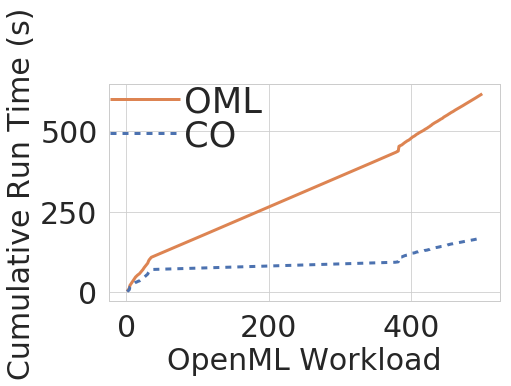

In [20]:
plot_executions_time(execution_times, y='cumulative_run_time',loc=output_directory+'/cumulative-runtime.pgf')
#plot_executions_time(execution_times)

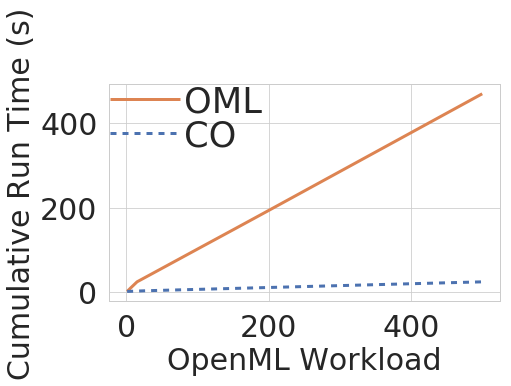

In [21]:
plot_executions_time(execution_times, y='cumulative_best_run_time',loc=output_directory+'/bestpipeline-overhead.pgf')

In [17]:
execution_times

,timestamp,exp_id,repo,pipeline,setup,type,score,current_run_time,best_setup,best_pipeline,best_score,best_run_time,total_run_time,cumulative_run_time,cumulative_best_run_time,cumulative_current_run_time,workload
0,22:31:36,49B19FDA,openml,5804,36487,CO,0.80,1.670847,5804,36487,0.80,1.670847,1.670857,1.670857,1.670847,1.670847,1
1,22:31:36,49B19FDA,openml,5909,36567,CO,0.80,1.687023,5804,36487,0.80,0.074086,1.761122,3.431979,1.744933,3.357870,2
2,22:31:36,49B19FDA,openml,5910,36868,CO,0.79,1.186056,5804,36487,0.80,0.082141,1.268206,4.700185,1.827074,4.543926,3
3,22:31:36,49B19FDA,openml,5913,43851,CO,0.71,2.222832,5804,36487,0.80,0.119809,2.342659,7.042844,1.946883,6.766758,4
4,22:31:36,49B19FDA,openml,5914,44102,CO,0.70,8.984627,5804,36487,0.80,0.097405,9.082062,16.124906,2.044288,15.751385,5
5,22:31:36,49B19FDA,openml,5909,47569,CO,0.80,1.769532,5804,36487,0.80,0.079027,1.848571,17.973477,2.123315,17.520917,6
6,22:31:36,49B19FDA,openml,5909,47570,CO,0.80,1.718978,5804,36487,0.80,0.080036,1.799029,19.772506,2.203351,19.239895,7
7,22:31:36,49B19FDA,openml,5909,47571,CO,0.80,1.692059,5804,36487,0.80,0.078545,1.770617,21.543123,2.281896,20.931954,8
8,22:31:36,49B19FDA,openml,5909,47572,CO,0.80,1.673417,5804,36487,0.80,0.070736,1.744166,23.287289,2.352632,22.605371,9
9,22:31:36,49B19FDA,openml,5909,47573,CO,0.80,1.695336,5804,36487,0.80,0.071607,1.766957,25.054246,2.424239,24.300707,10


In [8]:
def best_current_runs(df, loc=None):
    plt.figure(figsize=(10,4))
    plot = sns.lineplot(
        data=df,
        x='workload',
        y='cumulative_current_run_time',
        hue='type',
        style='type',
        #markers=["^", "o"],
        lw=3,
        hue_order=['OML', 'CO'],
       # style_order = ['baseline', 'optimized'],
        dashes=[(2, 2), (1, 0)],
        palette={
            'CO': SYSTEM_COLOR,
            'OML': BASELINE_COLOR
        },
        legend='brief')

    legend = plot.legend()
    legend.texts[0].set_text("")
    for line in legend.get_lines():
        line.set_linewidth(3.0)
    #top = df['run_time'].max()
    #cat.set_axis_labels('Execution Number', 'Run Time (s)')
    plot.set_xlabel('Workload', fontsize=22)
    plot.set_ylabel('Cumulative Run Time (s)', fontsize=22)
    #plot.set_xlim((1,2))
    #plot.set_ylim((0,2200))
    #plot.set_xticks(range(1,9))
    #plot.set_xticklabels(range(1,9))
    if loc is not None:
        plt.savefig(loc, bbox_inches ='tight')

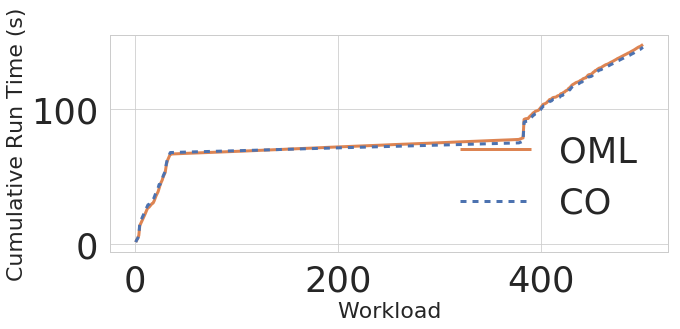

In [9]:
best_current_runs(execution_times)